In [25]:
class Node:
    def __init__(self, id, radius=None, total_time=None, level=0,end_point=None,E_UAV = None,E_UGV = None):
        self.id = id
        self.radius = radius
        self.total_time = total_time
        self.level = level
        self.children = []
        self.E_UAV = E_UAV
        self.E_UGV = E_UGV
        self.visit_count = 0
        self.end_point = end_point
        self.value = 0.0  # For MCTS
        self.parent = None  # For MCTS

    def add_child(self, node):
        """Adds a child to the current node."""
        node.level = self.level + 1
        node.parent = self  # Set parent for MCTS
        self.children.append(node)
        
    def delete_child(self, node):
        """Removes a child from the current node."""
        if node in self.children:
            self.children.remove(node)

    def display(self):
        """Displays the current node's information."""
        print(f"Node ID: {self.id}, Radius: {self.radius}, Total Time: {self.total_time}")

    def traverse(self):
        """Traverses and displays the tree starting from the current node."""
        self.display()
        for child in self.children:
            child.traverse()

    def get_nodes(self):
        """Returns all nodes in the tree starting from the current node."""
        nodes = [self]
        for child in self.children:
            nodes.extend(child.get_nodes())
        return nodes

    def ucb1(self, exploration_constant=1.41):
        """Calculates the UCB1 value for MCTS."""
        if self.visit_count == 0:
            return float('inf')
        parent_visits = self.parent.visit_count if self.parent is not None else 1
        return self.value / self.visit_count + exploration_constant * math.sqrt(
            math.log(parent_visits) / self.visit_count)

    def best_child(self):
        """Returns the best child based on UCB1 values."""
        return min(self.children, key=lambda node: node.ucb1(), default=None)

    def fully_expanded(self):
        """Checks if the node is fully expanded."""
        return len(self.radius) == len(waypoints) - 1  # -1 since the sequence length is one less than waypoints

    def update(self, reward):
        """Updates the node's value and visit count based on the given reward."""
        self.visit_count += 1
        self.value += reward




In [26]:
import numpy as np
from Common_function import *
import matplotlib.pyplot as plt
from itertools import product
import itertools

x = 3  #how are is the distance set
Total_E_UGV = 500000
Total_E_UAV = 15000
UAV_E_cost = 1250

UGV_E_cost_with_UAV = 1000
UGV_E_cost_without_UAV = 800
Charging_speed = 1000
speed_uav =30
speed_ugv =10
ten_minets = 1
survey_time = ten_minets/6
UAV_E_s_cost = 2500*ten_minets
print(UAV_E_s_cost)
# waypoints = [(20, 10), (24, 37), (36, 43), (8, 8), (0, 50), (30, 44), (28, 4), (32, 25)]
# # waypoints = [(20,10), (10,10),(15,30)]
# plan_output = "0 -> 1 -> 2 -> 0"
# plan_output = "0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 7 -> 6 -> 0"
waypoints = [(20,10), (10,10), (10,30), (20,30)]
plan_output = "0 -> 1 -> 2 -> 3 -> 0"
max_radius = ((Total_E_UAV - UAV_E_s_cost) / UAV_E_cost) / 2
radii = np.linspace(1.0, max_radius, x)
ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
ordered_points.append(ordered_points[0])


2500


In [27]:
import numpy as np

# I am assuming the functions like angle_between_points, point_on_circle, find_meeting_point_with_survey_final, etc. 
# are previously defined. However, as they are not provided here, I'll make the necessary modifications based on the code provided.

def compute_optimized_paths_for_radius_updated_v5(ordered_points, radius, speed_ugv, speed_uav, survey_time):
    UGV_outer_path = []
    UGV_path = [ordered_points[0]]
    UAV_path = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone = []
    chord_end = None
    prev_chord_end = None
    
    radius_set = []
    
    for i, point in enumerate(ordered_points[:-1]):
        # Replace current_radius with radius
        if 0 < i < len(ordered_points) - 2:
            # assuming angle_between_points and point_on_circle functions are defined previously
            angle = angle_between_points(ordered_points[i-1], ordered_points[i])
            nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
            chord_start = point_on_circle(ordered_points[i], angle - np.pi, radius)
            chord_end = point_on_circle(ordered_points[i], nextangle, radius)
            radius_set.append(radius)
            
            if prev_chord_end and i > 1 and circles_overlap(ordered_points[i], radius, ordered_points[i-1], radius):
                chord_start = prev_chord_end

            # assuming find_meeting_point_with_survey_final function is defined previously
            final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
                ordered_points[i], radius, chord_start, chord_end, 
                speed_ugv, speed_uav, survey_time
            )
     
            
            if chord_start:
                UAV_path_segment = [chord_start, point, final_meeting_point]
                UAV_path.append(UAV_path_segment)
                UGV_path.append(chord_start)
                # assuming calculate_UAV_inter_distances_inter function is defined previously
                # UAV_path_segment_distance = calculate_UAV_inter_distances_inter(UAV_path_segment)
                if i == 1:
                    UGV_outer_path.append([ordered_points[0], chord_start])
                else:
                    UGV_outer_path.append([prev_chord_end, chord_start])
                    
            if chord_end:
                UGV_path.append(chord_end)
            # assuming compute_distance function is defined previously
            inter_distance_without_drone = compute_distance(chord_start, final_meeting_point)
            inter_distance_with_drone = compute_distance(final_meeting_point, chord_end)
            UGVD_inter_without_drone.append(inter_distance_without_drone)
            UGVD_inter_with_drone.append(inter_distance_with_drone)
            prev_chord_end = chord_end
            end_point = chord_end
    UGV_path.append(ordered_points[-1])
    UGV_outer_path.append([chord_end,ordered_points[-1]])
    
    return radius_set, UGV_path, UAV_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time, end_point



In [28]:
def compute_path_for_one_point(ordered_points, point_index, radius, speed_ugv, speed_uav, survey_time):
    if point_index <= 0 or point_index >= len(ordered_points) - 1:
        raise ValueError("Invalid point index. It should be between 1 and len(ordered_points) - 2.")
    
    UGV_outer_path = []
    UGV_path = []
    UAV_path = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone = []
    chord_end = None
    prev_chord_end = None
    # final_wait_set = []
    radius_set = []
    final_wait_time = 0 
    point = ordered_points[point_index]
    
    # Assuming angle_between_points and point_on_circle functions are defined previously
    angle = angle_between_points(ordered_points[point_index - 1], ordered_points[point_index])
    nextangle = angle_between_points(ordered_points[point_index], ordered_points[point_index + 1])
    chord_start = point_on_circle(ordered_points[point_index], angle - np.pi, radius)
    chord_end = point_on_circle(ordered_points[point_index], nextangle, radius)
    radius_set.append(radius)
    
    if point_index > 1 and circles_overlap(ordered_points[point_index], radius, ordered_points[point_index - 1], radius):
        chord_start = prev_chord_end

    # Assuming find_meeting_point_with_survey_final function is defined previously
    final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
        ordered_points[point_index], radius, chord_start, chord_end, 
        speed_ugv, speed_uav, survey_time
    )
    final_wait_time = final_wait_time
    
    if chord_start:
        UAV_path_segment = [chord_start, point, final_meeting_point]
        UAV_path.append(UAV_path_segment)
        UGV_path.append(chord_start)

        # Assuming calculate_UAV_inter_distances_inter function is defined previously
        UAV_path_segment_distance = calculate_UAV_inter_distances_inter(UAV_path_segment)
        if point_index == 1:
            UGV_outer_path.append([ordered_points[0], chord_start])
        else:
            UGV_outer_path.append([prev_chord_end, chord_start])
        # print(f"UGV_outer_path:{UGV_outer_path}")
    if chord_end:
        UGV_path.append(chord_end)

    # Assuming compute_distance function is defined previously
    inter_distance_without_drone = compute_distance(chord_start, final_meeting_point)
    inter_distance_with_drone = compute_distance(final_meeting_point, chord_end)
    UGVD_inter_without_drone.append(inter_distance_without_drone)
    UGVD_inter_with_drone.append(inter_distance_with_drone)
    
    return radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time

# Note: This function assumes the existence of functions like angle_between_points, point_on_circle, 
# find_meeting_point_with_survey_final, etc. which are not provided here. So, this function won't run as-is without those definitions.


In [29]:
def calculate_UAV_inter_distances_inter(UAV_path):
    UAV_inter_distances = 0
    group_distance=0
    # print(f"what I got in function:{UAV_path}")
    for i in range(len(UAV_path) - 1):
        group_distance += compute_distance(UAV_path[i], UAV_path[i + 1])
    UAV_inter_distances=group_distance
    # print(f"UAV_path:{UAV_path},UAV_inter_distances{UAV_inter_distances}")
    return UAV_inter_distances

In [30]:

def tsp_output_to_tree(tsp_output, waypoints, radii):
    nodes_in_order = tsp_output.split()
    nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]
    pass_flag = 0
    # Create root node (start)
    root = Node(id=0, radius=None, total_time=0)
    
    # Global counter for node ID
    node_counter = [1]  # Using a list so it's mutable inside nested functions

    def add_node(parent, waypoint_index):
        if waypoint_index >= len(nodes_in_order):
            return

        for r in radii:
            
            
            
            if waypoint_index == 1:
                # print("------------Start-------------")
                radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time= compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)
                UGV_out_distance = compute_distance(ordered_points[0], UAV_path[0][0])
                UGV_inter_distance = compute_distance(UGV_path[0],UGV_path[1])
                UGV_distance = UGV_out_distance + UGV_inter_distance

                UAV_distances =UAV_path_segment_distance
                
                UGV_Trip_Cost = UGVD_inter_without_drone[0] * UGV_E_cost_without_UAV + UGV_out_distance * UGV_E_cost_with_UAV
                UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost

                charging_distance = UGVD_inter_with_drone[0]
                # print("at this point only the cost is considered")
                UGV_energy_remaining = Total_E_UGV - UGV_Trip_Cost
                UAV_energy_remaining = Total_E_UAV - UAV_Trip_Cost
                if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
                    return  # Indicating mission failed for both
                # print(f"UGV_energy_remaining:{UGV_energy_remaining},UAV_energy_remaining:{UAV_energy_remaining}")

                # print("start Charging Cal")
                charging_distance = UGVD_inter_with_drone[0]
                if UAV_energy_remaining < Total_E_UAV:
                    charge_amount = min(Charging_speed * charging_distance , UAV_Trip_Cost, UGV_energy_remaining)
                    UGV_energy_remaining -= charge_amount
                    UAV_energy_remaining += charge_amount
                    # print(f"charge_amount:{charge_amount}")
                    
                if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
                    pass_flag = 1
                    pass
                else:
                    pass_flag = 0
                


                print(UGV_energy_remaining,UAV_energy_remaining)
                total_time = parent.total_time  + final_wait_time +UGV_distance / speed_ugv

            elif waypoint_index == (len(nodes_in_order) -1):
                # print("------------end------------")
                UAV_path = []
                final_wait_time = 0
                UGV_path = [parent.end_point,ordered_points[-1]]
                UGV_distance = compute_distance(parent.end_point,ordered_points[-1])
                total_time = parent.total_time + UGV_distance / speed_ugv 

                UGV_energy_remaining =parent.E_UGV
                UAV_energy_remaining =parent.E_UAV
                
                UGV_Trip_Cost = UGV_distance * UGV_E_cost_with_UAV
                UAV_Trip_Cost = 0
                UGV_energy_remaining -= UGV_Trip_Cost
                if UGV_energy_remaining < 0:
                    pass_flag = 1
                    pass
                else:
                    pass_flag = 0
                # print(f"UGV_energy_remaining:{UGV_energy_remaining},UAV_energy_remaining:{UAV_energy_remaining}")
            else:
                # print("------------midpoints------------( take the UGV path outside before this point, find how much E is add on to drone, then find the cost )")
                radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time= compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)

                UGV_inter_distance = compute_distance(UGV_path[0],UGV_path[1])
                UGV_out_distance = compute_distance(parent.end_point,UGV_path[0])

                UGV_distance = UGV_out_distance + UGV_inter_distance

                UAV_distances =UAV_path_segment_distance
                
                UGV_Trip_Cost = UGVD_inter_without_drone[0] * UGV_E_cost_without_UAV + UGV_out_distance * UGV_E_cost_with_UAV
                UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost
                # print("at this point only the cost is considered")
                # print(f"UAV_Trip_Cost:{UAV_Trip_Cost},UGV_Trip_Cost:{UGV_Trip_Cost}")
                UAV_energy_remaining = parent.E_UAV
                UGV_energy_remaining = parent.E_UGV
                # print("start charging")
                charging_distance = UGV_out_distance
                if UAV_energy_remaining < Total_E_UAV:
                    charge_amount = min(Charging_speed * charging_distance , (Total_E_UAV - UAV_energy_remaining), UGV_energy_remaining)
                    UGV_energy_remaining -= charge_amount
                    UAV_energy_remaining += charge_amount
                    # print(f"charge_amount:{charge_amount},UAV_energy_remaining:{UAV_energy_remaining},UGV_energy_remaining:{UGV_energy_remaining}")
                
                UGV_energy_remaining = UGV_energy_remaining - UGV_Trip_Cost
                UAV_energy_remaining = UAV_energy_remaining - UAV_Trip_Cost
                
                charging_distance = UGVD_inter_with_drone[0]
                if UAV_energy_remaining < Total_E_UAV:
                    charge_amount = min(Charging_speed * charging_distance , (Total_E_UAV - UAV_energy_remaining), UGV_energy_remaining)
                    UGV_energy_remaining -= charge_amount
                    UAV_energy_remaining += charge_amount
                    # print(f"second part of charge_amount:{charge_amount},UAV_energy_remaining:{UAV_energy_remaining},UGV_energy_remaining:{UGV_energy_remaining}")
                

                # print(f"UGV_energy_remaining:{UGV_energy_remaining},UGV_Trip_Cost:{UGV_Trip_Cost}")
                # print(f"UAV_energy_remaining:{UAV_energy_remaining},UAV_Trip_Cost:{UAV_Trip_Cost}")
                if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
                    pass_flag = 1 
                    pass
                else: 
                    pass_flag = 0   
                    # print(f"UGV_energy_remaining:{UGV_energy_remaining},UAV_energy_remaining:{UAV_energy_remaining}")
                    total_time = parent.total_time  + UGV_distance / speed_ugv + final_wait_time

                

                # print(UGV_out_distance,parent.end_point,UGV_path[0])
            # print(total_time,waypoint_index)
            if pass_flag == 1:
                pass
            else:
                child = Node(id=node_counter[0], radius=r, total_time=total_time)
                parent.add_child(child)
                child.E_UGV = UGV_energy_remaining
                child.E_UAV = UAV_energy_remaining
                child.end_point = UGV_path[-1]
                node_counter[0] += 1  # Increment global node ID counter
                add_node(child, waypoint_index + 1)
                # print(f"id:{child.id}, R:{r}, UGV_path :{UGV_path},UAV_path:{UAV_path}")
    add_node(root, 1)

    return root



In [31]:

def calculate_energy_remaining_inter(Total_E_UGV, Total_E_UAV, UGV_out_distance, UGVD_inter_with_drone, UAV_distances_set , UAV_E_cost, UAV_E_s_cost, UGVD_inter_without_drone, UGV_E_cost_without_UAV, Charging_speed):
    UGV_energy_remaining = Total_E_UGV
    UAV_energy_remaining = Total_E_UAV

    
    UAV_distances = UAV_distances_set[i]
        
    UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost 
    UGV_Trip_Cost = UGVD_inter_without_drone[i] * UGV_E_cost_without_UAV
        
    UAV_energy_remaining -= UAV_Trip_Cost 
    UGV_energy_remaining -= UGV_Trip_Cost
        
    if UAV_energy_remaining < Total_E_UAV:
        charge_amount = min(Charging_speed * charging_distance , UAV_Trip_Cost, UGV_energy_remaining)
        UGV_energy_remaining -= charge_amount
        UAV_energy_remaining += charge_amount
        
        
    if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
        return -1, -1  # Indicating mission failed for both

    return UGV_energy_remaining, UAV_energy_remaining

In [32]:
root = tsp_output_to_tree(plan_output, waypoints, radii)

------------Start-------------
at this point only the cost is considered
UGV_energy_remaining:489868.6291501015,UAV_energy_remaining:10000.0
start Charging Cal
charge_amount:0.0
489868.6291501015 10000.0
------------midpoints------------( take the UGV path outside before this point, find how much E is add on to drone, then find the cost )
at this point only the cost is considered
UAV_Trip_Cost:5000.0,UGV_Trip_Cost:19131.370849898478
start charging
charge_amount:5000.0,UAV_energy_remaining:15000.0,UGV_energy_remaining:484868.6291501015
second part of charge_amount:0.0,UAV_energy_remaining:10000.0,UGV_energy_remaining:465737.258300203
UGV_energy_remaining:465737.258300203,UAV_energy_remaining:10000.0
------------midpoints------------( take the UGV path outside before this point, find how much E is add on to drone, then find the cost )
at this point only the cost is considered
UAV_Trip_Cost:5000.0,UGV_Trip_Cost:9131.370849898476
start charging
charge_amount:5000.0,UAV_energy_remaining:150

In [33]:
root.traverse()

Node ID: 0, Radius: None, Total Time: 0
Node ID: 1, Radius: 1.0, Total Time: 1.1333333333333333
Node ID: 2, Radius: 1.0, Total Time: 3.1666666666666665
Node ID: 3, Radius: 1.0, Total Time: 4.2
Node ID: 4, Radius: 1.0, Total Time: 6.1
Node ID: 5, Radius: 3.0, Total Time: 6.1
Node ID: 6, Radius: 5.0, Total Time: 6.1
Node ID: 7, Radius: 3.0, Total Time: 4.190930735378595
Node ID: 8, Radius: 1.0, Total Time: 5.890930735378595
Node ID: 9, Radius: 3.0, Total Time: 5.890930735378595
Node ID: 10, Radius: 5.0, Total Time: 5.890930735378595
Node ID: 11, Radius: 5.0, Total Time: 4.273773447853214
Node ID: 12, Radius: 1.0, Total Time: 5.773773447853214
Node ID: 13, Radius: 3.0, Total Time: 5.773773447853214
Node ID: 14, Radius: 5.0, Total Time: 5.773773447853214
Node ID: 15, Radius: 3.0, Total Time: 3.1575974020452615
Node ID: 16, Radius: 1.0, Total Time: 3.9909307353785946
Node ID: 17, Radius: 1.0, Total Time: 5.8909307353785945
Node ID: 18, Radius: 3.0, Total Time: 5.8909307353785945
Node ID: 19

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
def draw_tree(root):
    def add_edges(graph, node):
        for child in node.children:
            graph.add_edge(node.id, child.id)
            add_edges(graph, child)

    G = nx.DiGraph()
    add_edges(G, root)

    # Get all nodes and sort by level
    all_nodes = sorted(root.get_nodes(), key=lambda node: node.level)

    # Count nodes per level
    level_counts = defaultdict(int)

    # Assign positions
    pos = {}
    for node in all_nodes:
        pos[node.id] = (level_counts[node.level], -node.level)
        level_counts[node.level] += 1

    # Adjust x-positions to center nodes on each level
    for node in all_nodes:
        x_adjust = -0.5 * (level_counts[node.level] - 1)
        pos[node.id] = (pos[node.id][0] + x_adjust, pos[node.id][1])

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)

    # Edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, width=2)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Node data annotations
    for node in all_nodes:
        plt.annotate(
            f'T:{node.total_time:.2f}',
            xy=pos[node.id], textcoords='offset points', xytext=(-20,-30))

    plt.show()




In [35]:
def draw_tree(root):
    def add_edges(graph, node):
        for child in node.children:
            graph.add_edge(node.id, child.id)
            add_edges(graph, child)

    G = nx.DiGraph()
    add_edges(G, root)

    # Get all nodes and sort by level
    all_nodes = sorted(root.get_nodes(), key=lambda node: node.level)

    # Count nodes per level
    level_counts = defaultdict(int)

    # Assign positions
    pos = {}
    for node in all_nodes:
        pos[node.id] = (level_counts[node.level], -node.level)
        level_counts[node.level] += 1

    # Adjust x-positions to center nodes on each level
    for node in all_nodes:
        x_adjust = -0.5 * (level_counts[node.level] - 1)
        pos[node.id] = (pos[node.id][0] + x_adjust, pos[node.id][1])
    
    # Dynamic figure size
    num_nodes = len(all_nodes)
    num_levels = len(level_counts)
    fig_width = max(10, num_nodes * 0.5)
    fig_height = max(5, num_levels * 2)
    plt.figure(figsize=(fig_width, fig_height))

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)

    # Edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, width=2)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Node data annotations
    for node in all_nodes:
        plt.annotate(
            f'T:{node.total_time:.2f}',
            xy=pos[node.id], textcoords='offset points', xytext=(-20,-30))

    plt.show()


------------Start-------------
at this point only the cost is considered
UGV_energy_remaining:489868.6291501015,UAV_energy_remaining:10000.0
start Charging Cal
charge_amount:0.0
489868.6291501015 10000.0
------------midpoints------------( take the UGV path outside before this point, find how much E is add on to drone, then find the cost )
at this point only the cost is considered
UAV_Trip_Cost:5000.0,UGV_Trip_Cost:19131.370849898478
start charging
charge_amount:5000.0,UAV_energy_remaining:15000.0,UGV_energy_remaining:484868.6291501015
second part of charge_amount:0.0,UAV_energy_remaining:10000.0,UGV_energy_remaining:465737.258300203
UGV_energy_remaining:465737.258300203,UAV_energy_remaining:10000.0
------------midpoints------------( take the UGV path outside before this point, find how much E is add on to drone, then find the cost )
at this point only the cost is considered
UAV_Trip_Cost:5000.0,UGV_Trip_Cost:9131.370849898476
start charging
charge_amount:5000.0,UAV_energy_remaining:150

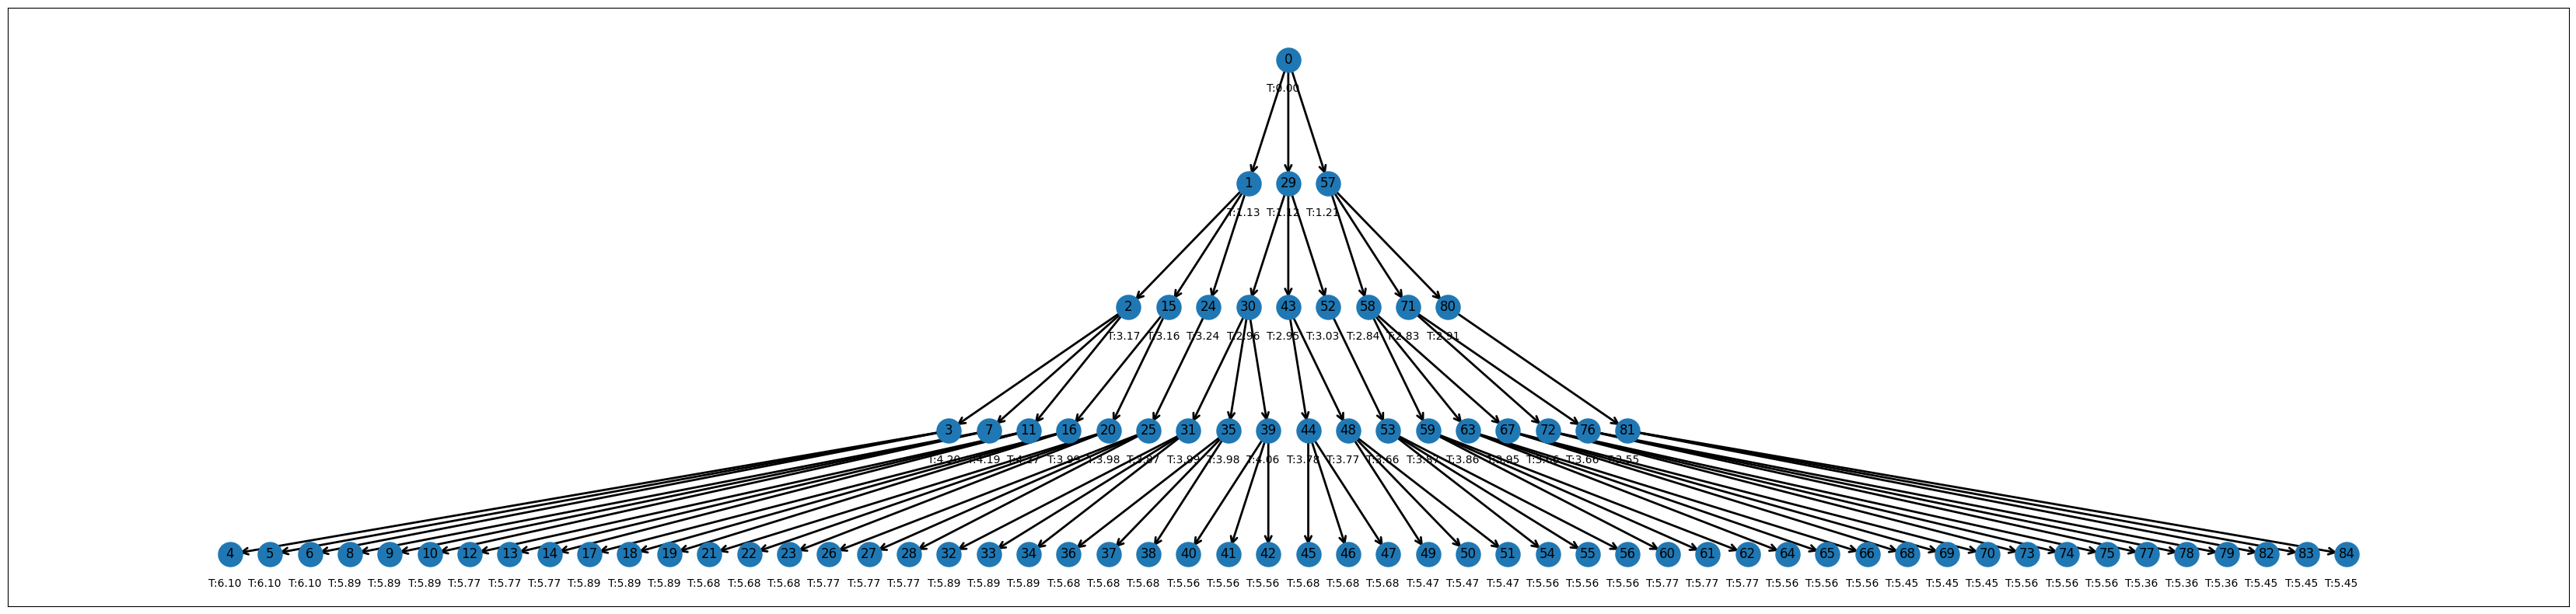

In [36]:
# Generating the tree
root_node = tsp_output_to_tree(plan_output, waypoints, radii)

# Drawing the tree
draw_tree(root_node)